In [1]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/Bayesian-Inference


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from dynamical_systems.SIR_models import *
import matplotlib.pyplot as plt

### Solve SIR Identifiable Dynamics

In [3]:
x0 = np.array([900,100,0]) # initial condition
true_theta_dyn = np.array([0.02,0.6,0.15]) # True parameters
t_eval = np.linspace(0,6,61)

sol = solve_SIR_forward(true_theta_dyn, sir_dynamics_identifiable, t_eval, x0)

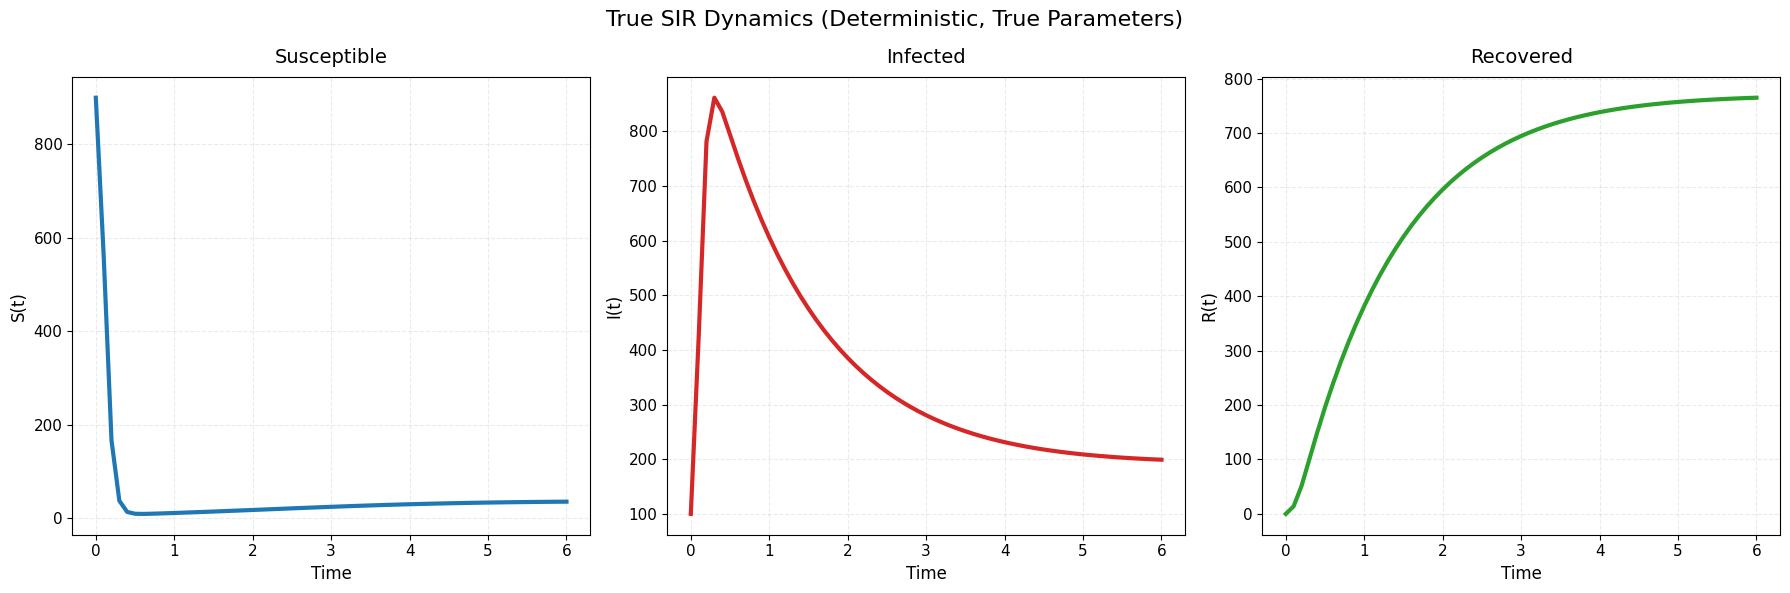

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

states  = ['Susceptible', 'Infected', 'Recovered']
colors  = ['#1f77b4', '#d62728', '#2ca02c']  # muted blue, red, green
ylabels = ['S(t)', 'I(t)', 'R(t)']

for i, ax in enumerate(axs):
    ax.plot(
        sol.t, sol.y[i],
        color=colors[i],
        lw=3.0
    )
    
    ax.set_title(states[i], fontsize=14, pad=10)
    ax.set_ylabel(ylabels[i], fontsize=12)
    ax.set_xlabel('Time', fontsize=12)
    
    ax.grid(True, alpha=0.25, linestyle='--')
    ax.tick_params(axis='both', labelsize=11)

fig.suptitle(
    'True SIR Dynamics (Deterministic, True Parameters)',
    fontsize=16
)
plt.tight_layout()
save_path_1 = os.path.join(ROOT, "images/Dynamical_systems/SIR_trueDynamics_identifiable.png")
plt.savefig(save_path_1, dpi=300)
plt.show()

## Generate Sensor Data

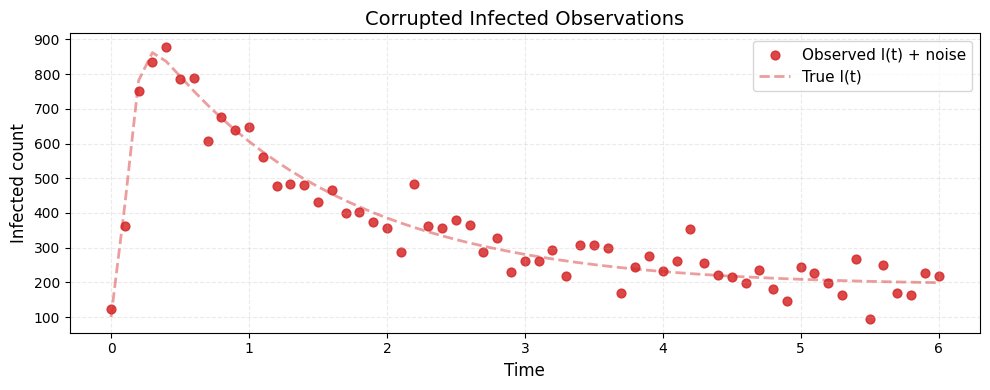

In [5]:
num_points  = 61
process_std = 50
whitenoise  = process_std * np.random.randn(num_points)
corrupted_I = sol.y[1] + whitenoise

plt.figure(figsize=(10, 4))

# Noisy observations as points
plt.scatter(
    sol.t,
    corrupted_I,
    s=40,                    # marker size instead of linewidth
    color="#d62728",
    alpha=0.85,
    label="Observed I(t) + noise"
)

# True infected trajectory (reference)
plt.plot(
    sol.t,
    sol.y[1],
    color="#d62728",
    lw=2.0,
    linestyle="--",
    alpha=0.45,
    label="True I(t)"
)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Infected count", fontsize=12)
plt.title("Corrupted Infected Observations", fontsize=14)

plt.grid(True, alpha=0.25, linestyle="--")
plt.legend(fontsize=11)
plt.tight_layout()
save_path_2 = os.path.join(ROOT, "images/Dynamical_systems/SIR_Corrupted_Observations.png")
plt.savefig(save_path_2, dpi=300)
plt.show()

# Laplace Approximation for SIR Identifiable

In [6]:
prior_mean = np.zeros(3)
prior_cov = np.identity(3)

logpost = lambda params: log_posterior_SIR(params, 
                                           corrupted_I, 
                                           process_std,
                                           t_eval, 
                                           sir_dynamics_identifiable, 
                                           prior_mean, 
                                           prior_cov)

guess = np.array([0,0,0]) # random guess
# guess = np.random.randn((3)) # random guess
map_point, cov_laplace = laplace_approx(guess, logpost)
print("map Point = ", map_point)
print("Laplace Covariance = \n" , cov_laplace)

map Point =  [0.01850918 0.62348693 0.16948175]
Laplace Covariance = 
 [[ 1.51539006e-06 -1.38757663e-06 -1.31456350e-06]
 [-1.38757663e-06  7.32412366e-04  4.22791903e-04]
 [-1.31456350e-06  4.22791903e-04  3.54418732e-04]]


## Apply DRAM for SIR Model

In [7]:
from mcmc.algorithms.dram import *
from mcmc.utils.mcmc_utils import *
from mcmc.diagnostics.autocorrelation import *
from mcmc.utils.run_helpers import *
from mcmc.diagnostics.iac_and_ess import *

In [8]:
target_logpdf = lambda x : log_posterior_SIR(x,
                                             corrupted_I,
                                             process_std,
                                             t_eval,
                                             sir_dynamics_identifiable,
                                             prior_mean,
                                             prior_cov)

val = target_logpdf(true_theta_dyn)
print(val, type(val), np.shape(val))

-27.453191547190496 <class 'numpy.float64'> ()


In [9]:
target_logpdf = lambda x : log_posterior_SIR(x,
                                             corrupted_I,
                                             process_std,
                                             t_eval,
                                             sir_dynamics_identifiable,
                                             prior_mean,
                                             prior_cov)

# initial conditions
initial_sample = map_point
initial_cov = cov_laplace # from Laplace Approximation
num_samples = 100000

# Proposal Distribution properties
proposal_logpdf = proposal_mvn_logpdf_eval
proposal_sampler = proposal_mvn_sampler

## Deyaled Rejection
dram_samples = dram_mcmc(initial_sample, initial_cov, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, k0=2000, freq_of_update=500, verbose=True)

samples = dram_samples.samples
print("Accepted Samples Ratio:", dram_samples.accept_rate)

Finished sample 1000, acceptance ratio = 0.794
Finished sample 2000, acceptance ratio = 0.781
Finished sample 3000, acceptance ratio = 0.767
Finished sample 4000, acceptance ratio = 0.752
Finished sample 5000, acceptance ratio = 0.736
Finished sample 6000, acceptance ratio = 0.730
Finished sample 7000, acceptance ratio = 0.728
Finished sample 8000, acceptance ratio = 0.724
Finished sample 9000, acceptance ratio = 0.719
Finished sample 10000, acceptance ratio = 0.716
Finished sample 11000, acceptance ratio = 0.712
Finished sample 12000, acceptance ratio = 0.711
Finished sample 13000, acceptance ratio = 0.709
Finished sample 14000, acceptance ratio = 0.709
Finished sample 15000, acceptance ratio = 0.707
Finished sample 16000, acceptance ratio = 0.705
Finished sample 17000, acceptance ratio = 0.705
Finished sample 18000, acceptance ratio = 0.702
Finished sample 19000, acceptance ratio = 0.701
Finished sample 20000, acceptance ratio = 0.699
Finished sample 21000, acceptance ratio = 0.698
F

In [10]:
new_mh_result= mcmc_burnin_and_thin(dram_samples, burnin_frac=0.2, thin_frac=1)
samples = new_mh_result.samples
print("Accepted Samples Ratio:", new_mh_result.accept_rate)

Accepted Samples Ratio: 0.6596125


In [11]:
print(np.sum(samples, axis=0)/samples.shape[0])

[0.01887648 0.63077838 0.17426698]


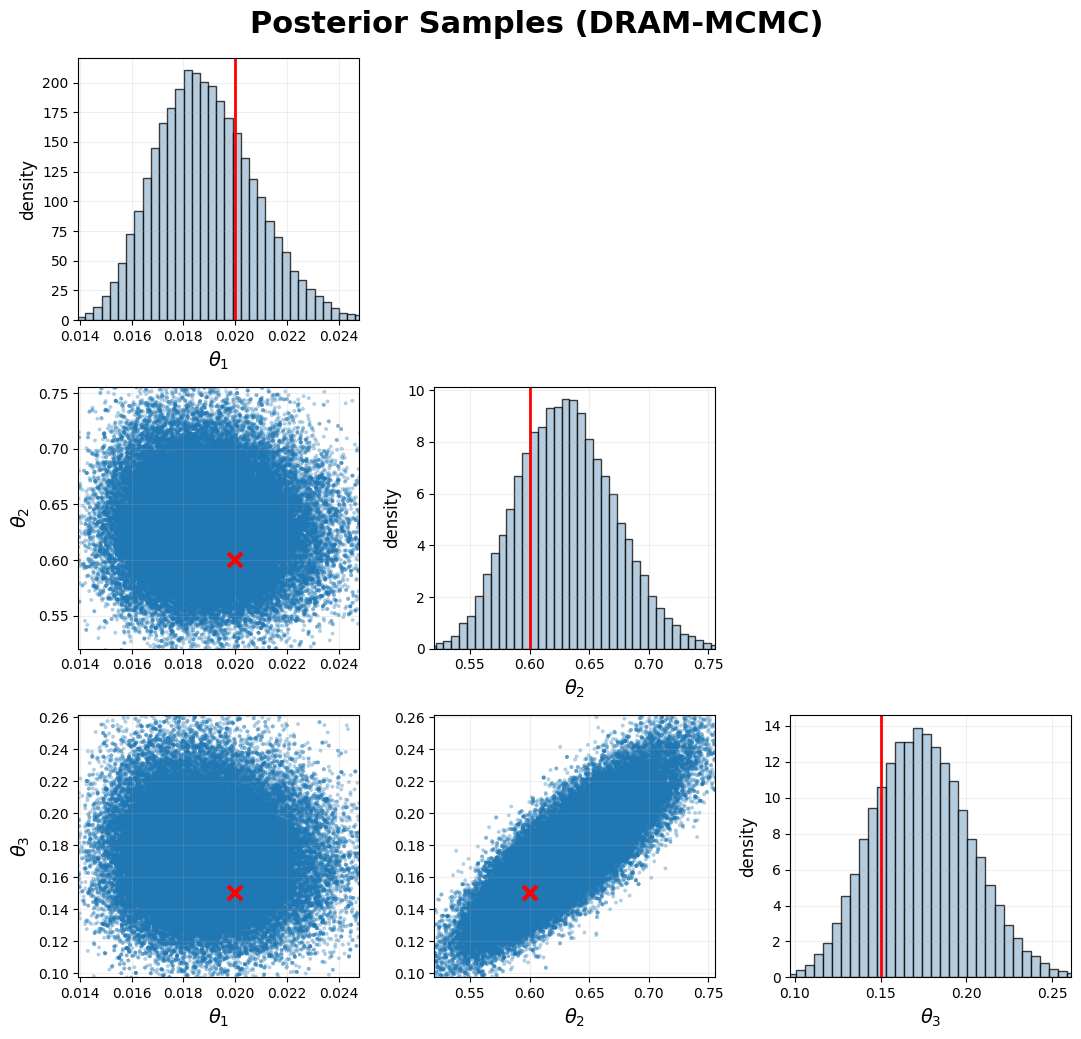

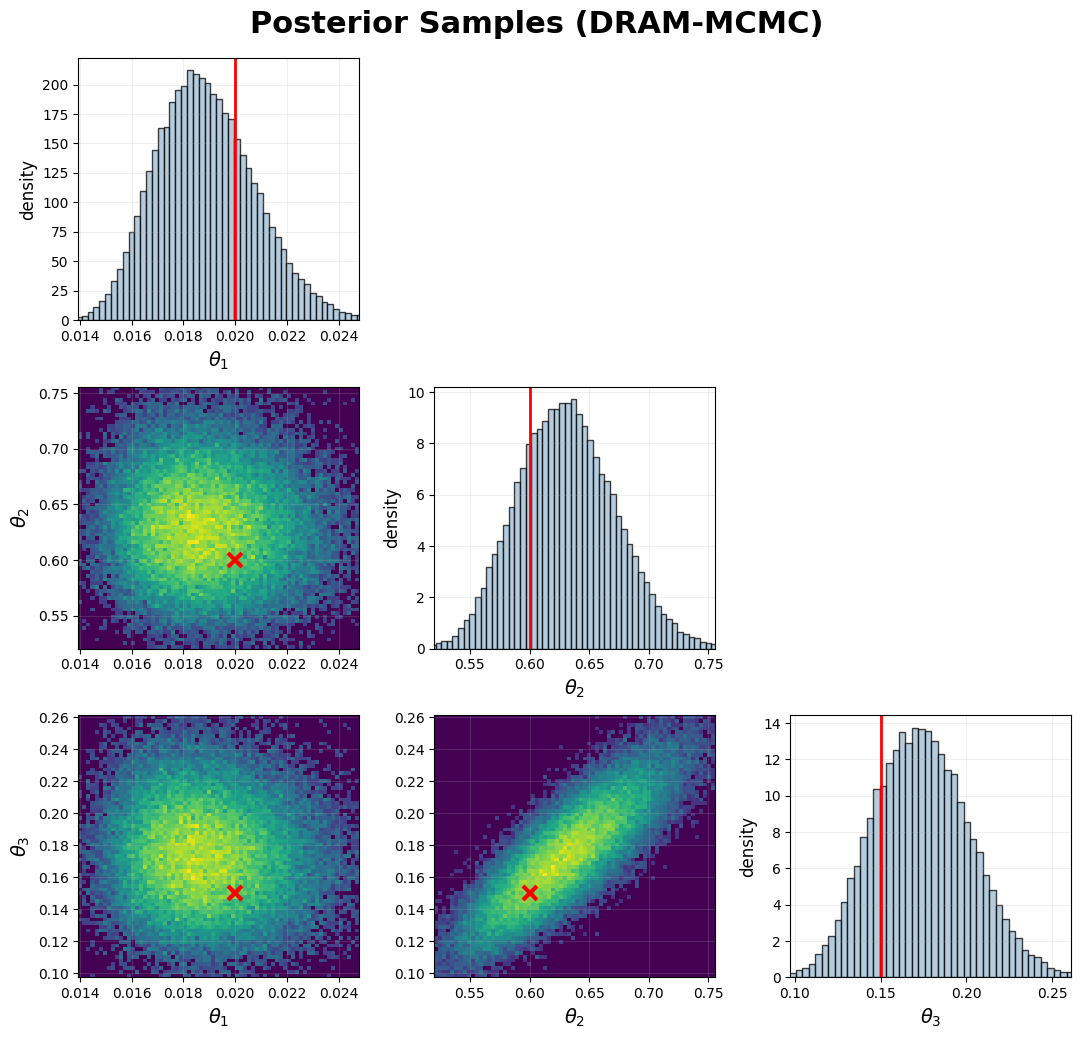

In [12]:
plt.close()
fig, axs, gs = scatter_matrix_clean(
    11,
    [samples],
    truths=true_theta_dyn,          # or None
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    hist_plot=False,
    suptitle="Posterior Samples (DRAM-MCMC)"
)
plt.show()

plt.close(12)
fig, axs, gs = scatter_matrix_clean(
    12,
    [samples],
    truths=true_theta_dyn,
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    hist_plot=True,
    nbins=70,
    suptitle="Posterior Samples (DRAM-MCMC)"
)
save_path_3 = os.path.join(ROOT, "images/Dynamical_systems/SIR_Identifiable_PosteriorSamples.png")
plt.savefig(save_path_3, dpi=300)
plt.show()

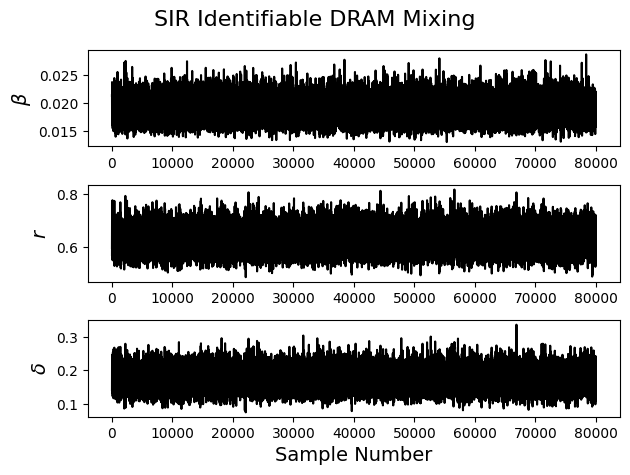

In [13]:
plt.close(4)
fig, axs = plt.subplots(3, 1, num=4)
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$\beta$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$r$', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$\delta$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)
fig.suptitle('SIR Identifiable DRAM Mixing', fontsize=16)
plt.tight_layout()
save_path_4 = os.path.join(ROOT, "images/Dynamical_systems/SIR_Identifable_mixing.png")
plt.savefig(save_path_4, dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

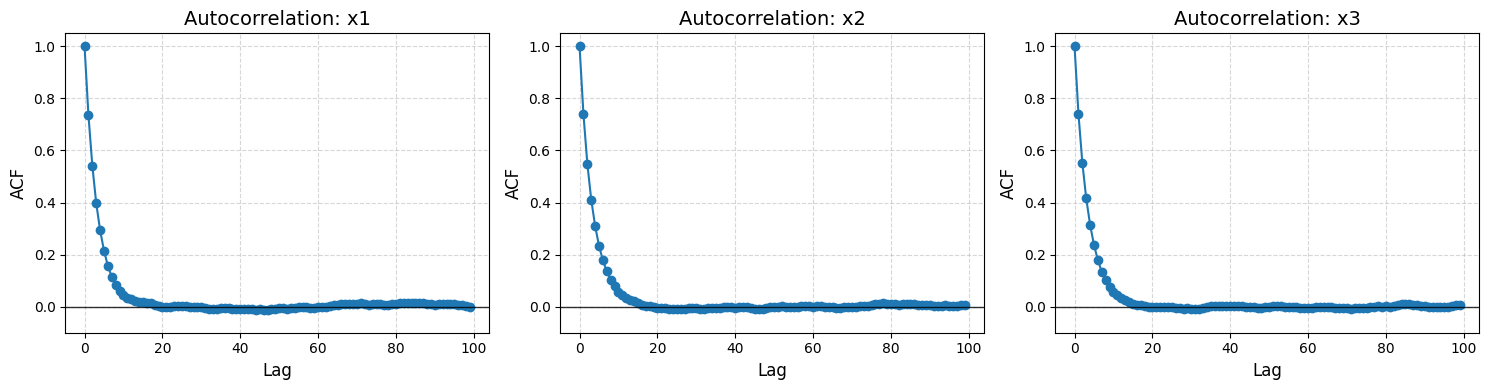

In [14]:
lags, acf = autocorrelation_vectorized(samples, max_lag=100)
save_path_5 = os.path.join(ROOT, "images/Dynamical_systems/SIR_Identifable_autocorrelation.png")
plt.savefig(save_path_5, dpi=300)
plot_autocorrelation_3d(lags, acf, dim_names=("x1", "x2", "x3"), save_path=save_path_5)

In [15]:
iac, acf, lags = integrated_autocorrelation(samples, max_lag=300)
ess = effective_sample_size(samples, iac)

N = samples.shape[0]
efficiency = ess / N * 100  # percentage

print(f"Total samples: {N}\n")

for k in range(len(iac)):
    print(f"Dimension {k}:")
    print(f"  IAC:          {iac[k]:.4f}")
    print(f"  ESS:          {ess[k]:.2f}")
    print(f"  Efficiency:   {efficiency[k]:.1f}%   "
          f"({efficiency[k]:.1f}% as effective as independent samples)")
    print()

Total samples: 80000

Dimension 0:
  IAC:          6.5997
  ESS:          12121.82
  Efficiency:   15.2%   (15.2% as effective as independent samples)

Dimension 1:
  IAC:          6.8854
  ESS:          11618.81
  Efficiency:   14.5%   (14.5% as effective as independent samples)

Dimension 2:
  IAC:          6.9097
  ESS:          11577.87
  Efficiency:   14.5%   (14.5% as effective as independent samples)



## Prior predictive Dynamics 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


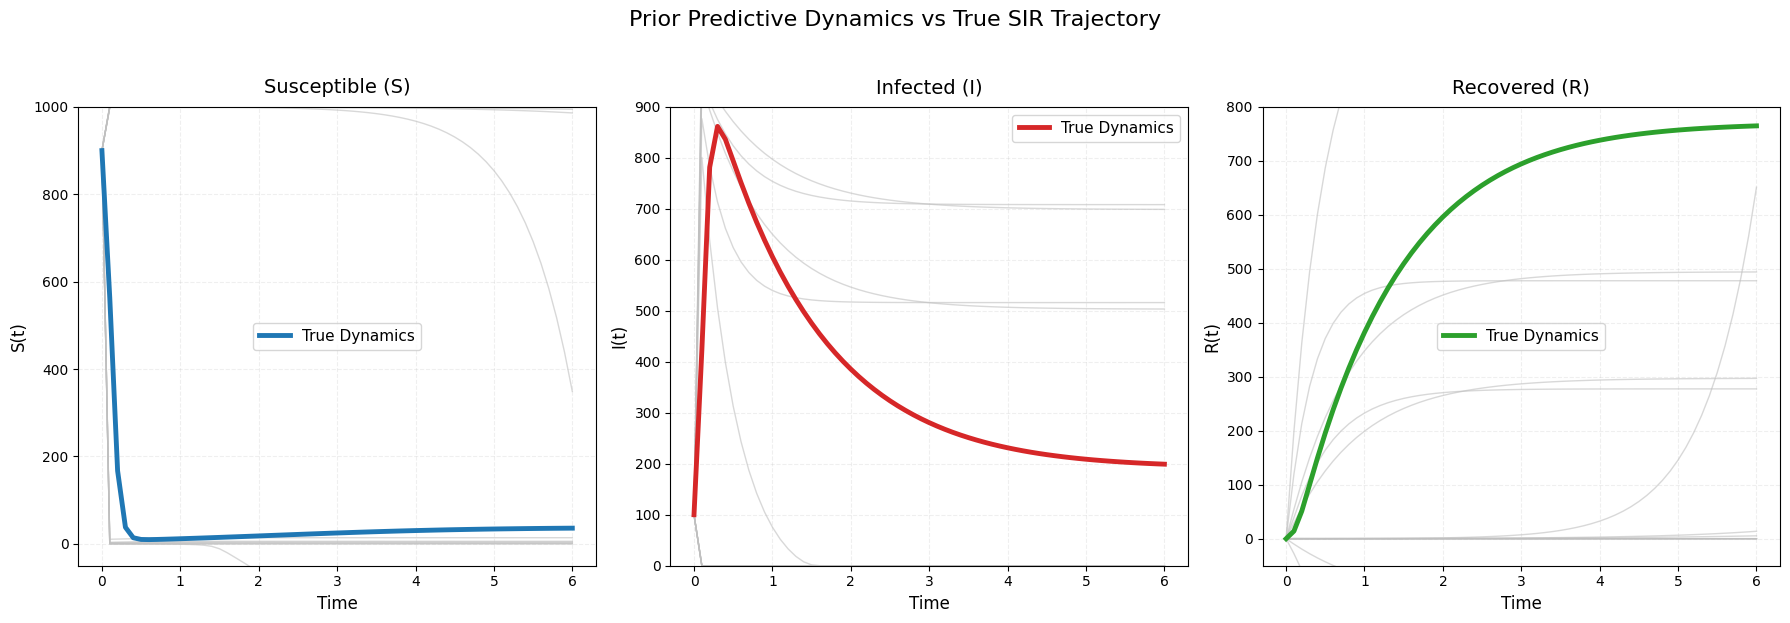

In [ ]:
# Prior predictive visualization (improved)

num_traj = 15 

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

titles  = ['Susceptible (S)', 'Infected (I)', 'Recovered (R)']
ylabels = ['S(t)', 'I(t)', 'R(t)']
colors_true = ['#1f77b4', '#d62728', '#2ca02c']

for ax, title, ylabel in zip(axs, titles, ylabels):
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='--')

axs[0].set_ylim(-50, 1000)
axs[1].set_ylim(0, 900)
axs[2].set_ylim(-50, 800)

# --- Prior predictive trajectories ---
for i in range(num_traj):
    theta_sample = proposal_mvn_sampler(prior_mean, prior_cov)
    sol = solve_SIR_forward(theta_sample, sir_dynamics_identifiable, t_eval, x0)
    
    axs[0].plot(sol.t, sol.y[0], color='0.75', lw=1.0, alpha=0.6)
    axs[1].plot(sol.t, sol.y[1], color='0.75', lw=1.0, alpha=0.6)
    axs[2].plot(sol.t, sol.y[2], color='0.75', lw=1.0, alpha=0.6)
    print(i)
    
# --- True dynamics ---
sol_true = solve_SIR_forward(true_theta_dyn, sir_dynamics_identifiable, t_eval, x0)

axs[0].plot(sol_true.t, sol_true.y[0],
            color=colors_true[0], lw=3.5, label='True Dynamics')

axs[1].plot(sol_true.t, sol_true.y[1],
            color=colors_true[1], lw=3.5, label='True Dynamics')

axs[2].plot(sol_true.t, sol_true.y[2],
            color=colors_true[2], lw=3.5, label='True Dynamics')

for ax in axs:
    ax.legend(fontsize=11)

fig.suptitle(
    'Prior Predictive Dynamics vs True SIR Trajectory',
    fontsize=16,
    y=1.03
)

plt.tight_layout()
save_path_6 = os.path.join(ROOT, "images/Dynamical_systems/SIR_Identifable_priorPredictive.png")
plt.savefig(save_path_6, dpi=300)
plt.show()


## Posterior Predictive Dynamics

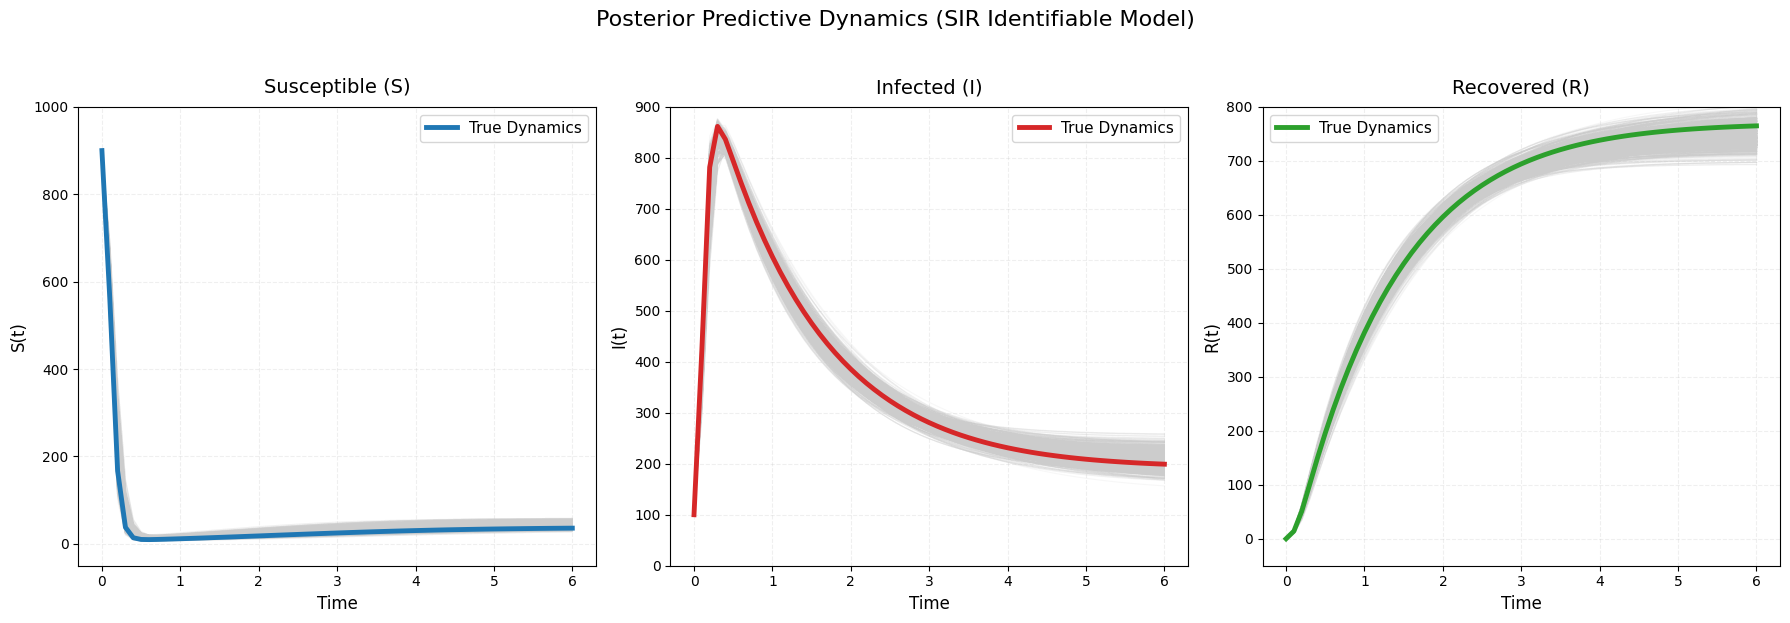

In [28]:
# Posterior predictive visualization (improved)

num_traj = 1000
posteriorData = samples[-num_traj:, :]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

titles  = ['Susceptible (S)', 'Infected (I)', 'Recovered (R)']
ylabels = ['S(t)', 'I(t)', 'R(t)']
colors_true = ['#1f77b4', '#d62728', '#2ca02c']

for ax, title, ylabel in zip(axs, titles, ylabels):
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='--')

axs[0].set_ylim(-50, 1000)
axs[1].set_ylim(0, 900)
axs[2].set_ylim(-50, 800)

# --- Posterior predictive trajectories ---
for i in range(num_traj):
    theta_post = posteriorData[i, :]
    sol = solve_SIR_forward(theta_post, sir_dynamics_identifiable, t_eval, x0)
    
    axs[0].plot(sol.t, sol.y[0], color='0.8', lw=0.8, alpha=0.15)
    axs[1].plot(sol.t, sol.y[1], color='0.8', lw=0.8, alpha=0.15)
    axs[2].plot(sol.t, sol.y[2], color='0.8', lw=0.8, alpha=0.15)

# --- True dynamics ---
sol_true = solve_SIR_forward(true_theta_dyn, sir_dynamics_identifiable, t_eval, x0)

axs[0].plot(sol_true.t, sol_true.y[0],
            color=colors_true[0], lw=3.5, label='True Dynamics')

axs[1].plot(sol_true.t, sol_true.y[1],
            color=colors_true[1], lw=3.5, label='True Dynamics')

axs[2].plot(sol_true.t, sol_true.y[2],
            color=colors_true[2], lw=3.5, label='True Dynamics')

for ax in axs:
    ax.legend(fontsize=11)

fig.suptitle(
    'Posterior Predictive Dynamics (SIR Identifiable Model)',
    fontsize=16,
    y=1.03
)

plt.tight_layout()
save_path_7 = os.path.join(ROOT, "images/Dynamical_systems/SIR_Identifable_PosteriorPredictive.png")
plt.savefig(save_path_7, dpi=300)
plt.show()